# Create multi layer perceptron model with MNIST data


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
cd /content/drive/MyDrive/colab/

[WinError 3] 지정된 경로를 찾을 수 없습니다: '/content/drive/MyDrive/colab/'
C:\Users\whoe9\Desktop\jupyternotebook\Pytorch


## 1. Module Import

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # neural network를 만들 때 필요한 함수를 모아놓은 모듈
import torch.nn.functional as F # torch.nn 중에서도 자주 사용되는 함수
from torchvision import transforms, datasets # CV분야에서 자주 사용되는 torchvision 

## 2. Check version

In [2]:

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
DEVICE

device(type='cpu')

In [4]:
torch.__version__

'1.9.0'

In [34]:
batch_size = 32
epoch = 10

In [6]:
pwd

'C:\\Users\\whoe9\\Desktop\\jupyternotebook\\Pytorch'

## 3. MNIST 데이터 다운로드(train, test 분리)

`datasets.MNIST`를 이용해서 데이터를 불러올 수 있고, 이미지 형태이기 때문에 `transforms.ToTensor` 옵션을 사용해 텐서형태로 불러옴. 다만 MLP 모델은 input data의 값이 커질수록 불안정해지므로 정규화를 0\~255 사이의 텐서값을 0~1 범위로 정규화하여 불러움

In [9]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = False,
                               download = True,
                               transform = transforms.ToTensor())

In [11]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

위에서 다운로드한 MNIST 데이터셋을 미니 배치 단위로 분리해서 지정. 이미지 데이터를 배치 사이즈 단위로 미니 배치를 구성하게 됨.  
즉, 미니 배치 1개 = 배치 사이즈 32

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

**미니 배치**  
총 60,000개의 손글씨 사진들을 전부 비교하기에는 시공간적으로 효율적이지 못함.  
때문에 미니배치라는 전체 데이터의 일부만을 학습에 이용하는 방법.    
- 1 epoch : 32개 학습 -> 가중치 업데이트 -> 그다음 32개 학습 -> ... -> 총 60,000/32  = 1,875번 학습

## 4. 데이터 확인하기 (1)

In [17]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


출력 결과 해석  
- 32개의 이미지 데이터가 1개의 미니 배치를 구성
- 가로 28, 세로 28 픽셀
- 채널 1 -> Gray Scale (흑백)
- type 도 추가로 확인할 수 있음

## 5. 데이터 확인하기 (2)

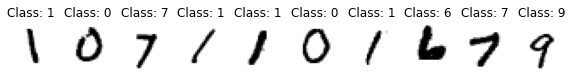

In [20]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = "gray_r")
    plt.title("Class: " + str(y_train[i].item()))

## 6. MLP 모델링

- `nn.Linear` : affine 변환을 담당하는 layer 

In [22]:
class Net(nn.Module): # nn.Module method 상속 -> nn.Module 내의 함수를 Net class 안에서 이용가능함
    
    # 초기화
    def __init__(self):
        super(Net, self).__init__()
        # Fully Connected Layer
        self.fc1 = nn.Linear(28 * 28, 512) # 처음 input layer의 노드수 = 가로*세로*채널수 
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 10) # Output : 0~9까지의 이미지 label -> 10개 // Loss를 계산하기 위해서 개수 똑같이 맞춰야 함
    
    # 순전파
    def forward(self, x):
        x = x.view(-1, 28*28) # MLP 모델은 1차원 데이터를 입력 받음. 기존 데이터는 (28, 28)의 2차원 데이터이므로 view를 이용하여 28*28개의 1차원 데이터로 변환
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

model = Net().to(DEVICE)

In [28]:
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


**파라미터 확인**

In [25]:
for name, param in model.named_parameters():
    print(f'name:{name}') 
    print(type(param)) 
    print(f'param.shape:{param.shape}')
    print(f'param.requries_grad:{param.requires_grad}')
    print('=====')

name:fc1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([512, 784])
param.requries_grad:True
=====
name:fc1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([512])
param.requries_grad:True
=====
name:fc2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([256, 512])
param.requries_grad:True
=====
name:fc2.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([256])
param.requries_grad:True
=====
name:fc3.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([10, 256])
param.requries_grad:True
=====
name:fc3.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([10])
param.requries_grad:True
=====


## 7. 옵티마이저, 손실함수 설정

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # stochastic gradient descent 
criterion = nn.CrossEntropyLoss() # 손실함수 : CrossEntropy

[Cross Entropy Loss function](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in Pytorch

## 8. train 데이터에 대한 모델 성능 확인하는 함수 정의

In [44]:
def train(model, train_loader, optimizer, log_interval):
    model.train() # 정의한 모델을 학습 상태로 지정
    for batch_idx,(image, label) in enumerate(train_loader): 
        image = image.to(DEVICE) # 사용할 이미지(인풋)와 레이블을 GPU 또는 CPU에 할당
        label = label.to(DEVICE) # true y값
        optimizer.zero_grad() # 그래디언트 초기화
        output = model(image) # prediction 값, train_loader부터 입력된 이미지 데이터를 input에 넣어 MLP 모델을 돌리고 결과를 output에 저장
        loss = criterion(output, label) # Loss 함수로 평가
        loss.backward() # loss함수를 최소화하도록 계산된 그래디언트로 역전파
        optimizer.step() # 파라미터 값 업데이트, 다음 에포크 실행

        if batch_idx % log_interval == 0:
            print("Train Epoch {} [ {}/{} ({:.0f}%) ] /t Train Loss: {:.6f}".format(ep, 
                                                                                batch_idx * len(image),
                                                                                len(train_loader.dataset), 
                                                                                100. * batch_idx / len(train_loader),
                                                                                loss.item()))

## 9. test 데이터에 대한 모델 성능 확인하는 함수 정의

In [38]:
def evaluate(model, test_loader):
    model.eval() # 평가 모드
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1] #output은 크기가 10이며, input에 대한 각각 label의 예측 확률값 벡터값임. 확률이 가장 높은(max) label로 분류하는 것임.
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 실제와 예측값이 맞으면 correct에 +1

    test_loss /= len(test_loader.dataset) # 전체 loss를 미니배치 총 개수만큼 나눔 (1875개)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [39]:
import datetime as dt

In [43]:
start = dt.datetime.now()
for ep in range(1, epoch+1):
    train(model, train_loader, optimizer, log_interval = 200) 
    #위에서 train 함수를 통해 설정된 파라미터로 test셋에 적합하여 loss와 accuracy 계산
    test_loss, test_accuracy = evaluate(model, test_loader) 
    
    """train의 결과를 따로 저장하지 않고도 아래에서 바로 평가하는 것을 볼 때,
    model.train()을 통해 학습모델에서 추정된 파라미터를 고정하고,
    별도로 할당하는 것 없이 model.test()에 이용하는 듯"""
    
    print(f"\[EPOCH: {ep}], \t Test Loss : {test_loss:.4f}, \t Test Accuracy : {test_accuracy:.2f} \n")

end = dt.datetime.now()
print(end - start)

Train Epoch 1 [ 0/60000 0%) ] /t Train Loss: 2.373925
Train Epoch 1 [ 6400/60000 11%) ] /t Train Loss: 2.279435
Train Epoch 1 [ 12800/60000 21%) ] /t Train Loss: 2.307403
Train Epoch 1 [ 19200/60000 32%) ] /t Train Loss: 2.303364
Train Epoch 1 [ 25600/60000 43%) ] /t Train Loss: 2.317318
Train Epoch 1 [ 32000/60000 53%) ] /t Train Loss: 2.295982
Train Epoch 1 [ 38400/60000 64%) ] /t Train Loss: 2.268548
Train Epoch 1 [ 44800/60000 75%) ] /t Train Loss: 2.309198
Train Epoch 1 [ 51200/60000 85%) ] /t Train Loss: 2.283495
Train Epoch 1 [ 57600/60000 96%) ] /t Train Loss: 2.284096
\[EPOCH: 1], 	 Test Loss : 0.0694, 	 Test Accuracy : 27.04 

Train Epoch 2 [ 0/60000 0%) ] /t Train Loss: 2.228342
Train Epoch 2 [ 6400/60000 11%) ] /t Train Loss: 2.207078
Train Epoch 2 [ 12800/60000 21%) ] /t Train Loss: 2.155443
Train Epoch 2 [ 19200/60000 32%) ] /t Train Loss: 2.083037
Train Epoch 2 [ 25600/60000 43%) ] /t Train Loss: 1.994179
Train Epoch 2 [ 32000/60000 53%) ] /t Train Loss: 1.631279
Train E

**결과**
- CPU 사용
- 모델 총 소요시간 : 약 1분 54초
- test accuracy : 90.38 %

## 배운 것
- 신경망 모형을 직접 돌려보고 학습시킨 것은 이번이 처음이라 처음부터 끝까지가 새로운 것이었음.
- 역전파 과정을 깊게 생각하지 않고 직관적으로 생각하기 위해 노력함.
- 전반적인 모델링 과정은 다른 모형들과 비슷하지만, 이미지 데이터를 학습시켰기에 세부적인 것들이 달랐음.
- 이미지 데이터라 데이터 하나하나의 feature가 채널, x, y로 구성되었으며,
- 미니배치와 SGD를 이용한 학습을 배웠음.
- 인풋과 아웃풋의 정의를 확실히 하고, 배치 사이즈, 옵티마이저, 손실함수의 개념을 확실히 짚고 넘어갈 필요성을 느낌